In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [49]:
# 1. Memuat dan Menyiapkan Data
data = pd.read_csv(r'/content/HistoricalData_1721543882668.csv')
print(data.columns)  # Menggunakan harga penutupan

Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')


In [50]:
# Memastikan nama kolom tidak memiliki spasi tambahan
data.columns = data.columns.str.strip()

In [51]:
# Menghapus simbol dolar dan mengonversi kolom menjadi float
data['Close/Last'] = data['Close/Last'].str.replace('$', '').astype(float)

In [52]:
# Menggunakan kolom yang benar, misalnya jika nama kolomnya 'Close/Last'
data = data[['Close/Last']]  # Sesuaikan dengan nama kolom yang benar
data = data.rename(columns={'Close/Last': 'Close'})  # Menyederhanakan nama kolom

In [53]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [54]:
# Membagi Data
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[training_data_len - 60:, :]

In [55]:
# Membuat Dataset untuk LSTM
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(len(data)-time_step-1):
        x.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

time_step = 60
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [56]:
# Mengubah data menjadi bentuk yang sesuai untuk LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [57]:
# Membangun dan Melatih Model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [58]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2331/2331 [==============================] - 21s 7ms/step - loss: 5.5130e-04
Epoch 2/5
2331/2331 [==============================] - 18s 8ms/step - loss: 2.7800e-04
Epoch 3/5
2331/2331 [==============================] - 17s 7ms/step - loss: 2.2766e-04
Epoch 4/5
2331/2331 [==============================] - 18s 8ms/step - loss: 1.5958e-04
Epoch 5/5
2331/2331 [==============================] - 18s 8ms/step - loss: 1.3481e-04


In [59]:
# Membuat Prediksi
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 4ms/step


In [60]:
# Mengembalikan y_test ke skala aslinya
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [61]:
# Evaluasi Metrik
mse = mean_squared_error(y_test_scaled, predictions)
rmse = sqrt(mse)
print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 0.24624233436268966, RMSE: 0.49622810718729915


In [62]:
# Evaluasi dan Visualisasi Hasil
train = data[:training_data_len]
valid = data[training_data_len:]

In [63]:
# Sesuaikan panjang valid dengan prediksi
valid = valid.iloc[:len(predictions)]

valid['Predictions'] = predictions

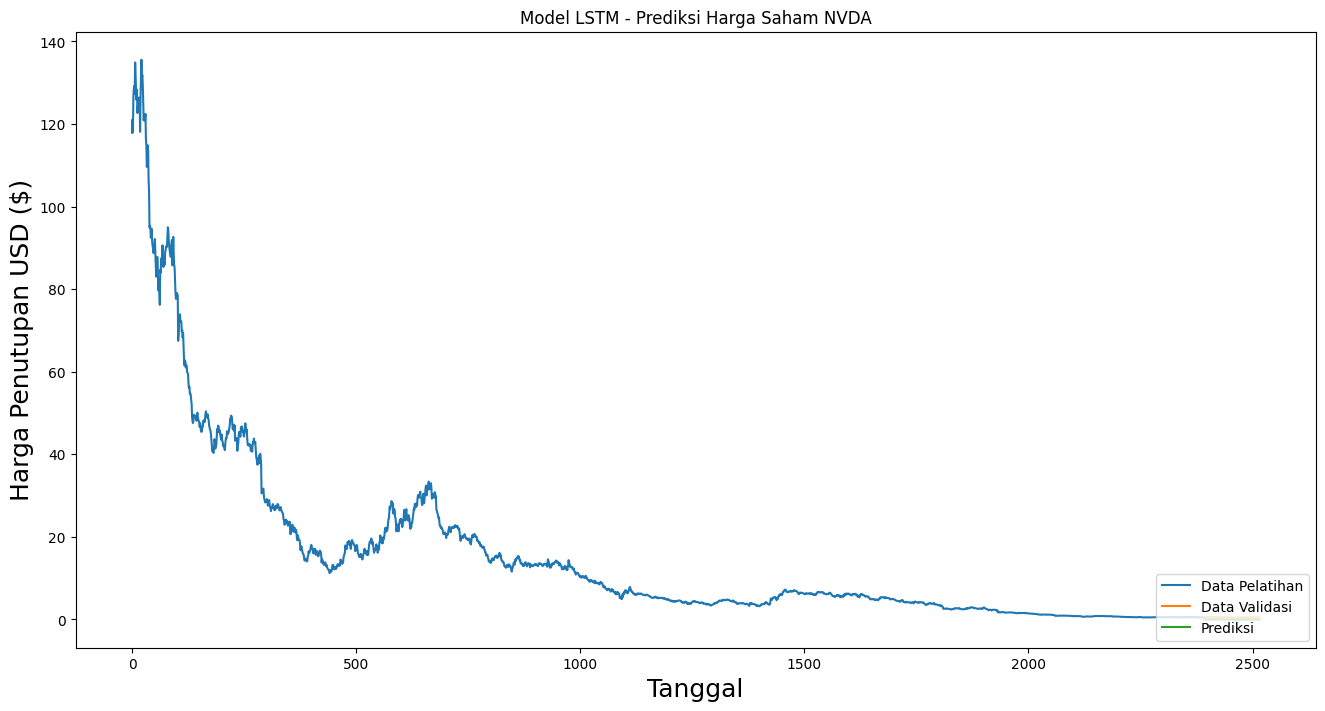

In [64]:
plt.figure(figsize=(16,8))
plt.title('Model LSTM - Prediksi Harga Saham NVDA')
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Harga Penutupan USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Data Pelatihan', 'Data Validasi', 'Prediksi'], loc='lower right')
plt.show()